In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import joblib
from clean_dataframe import X_Y_split, clean_dataframe
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from functions import XGBoost_Model
%load_ext autoreload

In [2]:
model_loc = "./Experiments/exp_4/MODELS/initial_model"
test_model = joblib.load(model_loc)

In [3]:
test_1_data = pd.read_csv("./Experiments/exp_1/test_data/test_1/test_1.csv")

In [4]:
cleaned_data = clean_dataframe(test_1_data)
#cleaned_data.head()

In [5]:
train_data = cleaned_data.sample(frac=0.01)
train_x, train_y = X_Y_split(train_data)
train_x.shape

(2746, 7)

# Hyperparameter Tuning

In [14]:
parameters = {
    'learning_rate': np.linspace(0.01,0.6,10),
    'max_depth' : np.arange(3,len(cleaned_data.columns),2),
    'subsample' : np.linspace(0.7,1.0,4),
    'colsample_by_tree' : np.linspace(0.7,1.0,4),
    #'n_estimators' : np.arange(100, 1000,100),
    'reg_alpha' : np.linspace(0,100,num=10),
    'reg_lambda' : np.linspace(0,100, num = 10),
    'gamma' : np.linspace(0,100, num = 5),
}

In [25]:
def tune_parameter(parameter, param_range, save_plot=False, randomized=False,
                  n_iter = None, n_splits=5,estimator=None):

    param_grid = {parameter : list(param_range)}
    kfold = KFold(n_splits=n_splits, random_state=7)
    if not estimator:
        estimator = xgb.XGBRegressor(objective="reg:squarederror", )
    if randomized:
        assert n_iter != None, "Missing number of iterations"
        param_search = RandomizedSearchCV(estimator,param_grid,n_iter=n_iter,
                                          scoring="neg_mean_squared_error",cv=kfold)
    else:
        param_search = GridSearchCV(estimator, param_grid, verbose=0, cv=kfold, scoring="neg_mean_squared_error")
    grid_result = param_search.fit(train_x, train_y, verbose=0)
    
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    #for mean, stdev, param in zip(means, stds, params):
        #print("%f (%f) with: %r" % (mean, stdev, param))
        
    if randomized:
        param_range = [list(i.values())[0] for i in params]
        
    fig, ax = plt.subplots()
    ax.errorbar(param_range, -1*means, yerr=stds)
    ax.set_title(f"XGBoost {parameter} vs RMSE")
    ax.set_xlabel(f"{parameter}")
    ax.set_ylabel("RMSE")
    fig.savefig("%s.png"%parameter)
    
    return grid_result

In [50]:
def tune_all(estimator, param_grid, n_iter=10,n_splits=5):
    kfold = KFold(n_splits=n_splits)
    param_search = RandomizedSearchCV(estimator,param_grid,n_iter=n_iter,
                                          scoring="neg_mean_squared_error",cv=kfold,n_jobs=4)
    grid_result = param_search.fit(train_x, train_y, verbose=0)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    return grid_result

In [51]:
tune_all(test_model, parameters, n_iter=5,n_splits=2)

exception calling callback for <Future at 0x12888a080 state=finished raised BrokenProcessPool>
sklearn.externals.joblib.externals.loky.process_executor._RemoteTraceback: 
'''
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py", line 391, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/__init__.py", line 11, in <module>
    from .core import DMatrix, Booster
  File "/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/core.py", line 22, in <module>
    from .compat import (STRING_TYPES, PY3, DataFrame, MultiIndex, py_str,
  File "/usr/local/lib/python3.7/site-packages/xgboost-0.90-py3.7.egg/xgboost/c

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

Best: -6.234258 using {'learning_rate': 0.20666666666666667}
Best: -6.131401 using {'max_depth': 7}
Best: -5.974269 using {'subsample': 0.7999999999999999}
Best: -6.272910 using {'colsample_by_tree': 0.7}
Best: -6.061213 using {'reg_alpha': 33.33333333333333}
Best: -5.989755 using {'reg_lambda': 100.0}
Best: -5.982670 using {'gamma': 25.0}


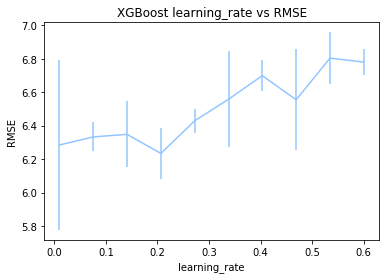

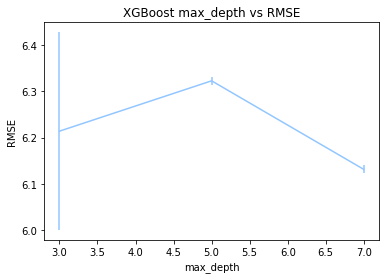

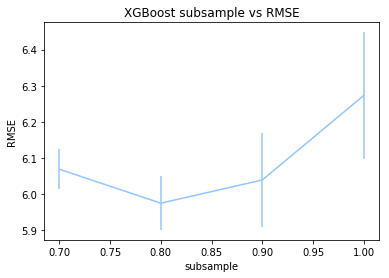

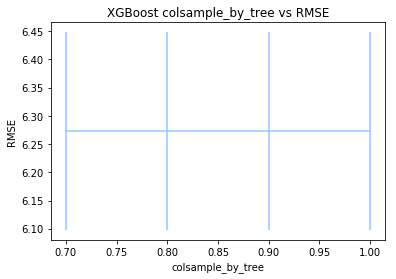

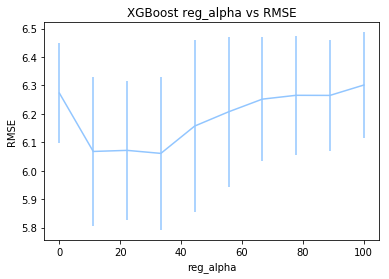

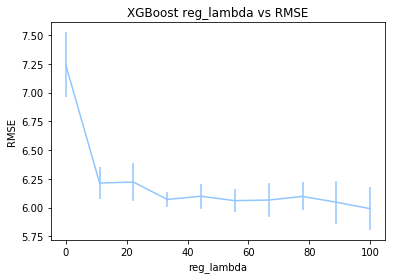

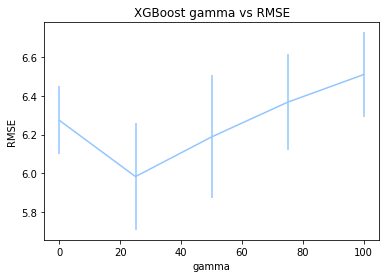

In [29]:
#tuning_param = "n_estimators"
final_results = {}
for tuning_param in list(parameters.keys()):
    n_iter = len(parameters.get(tuning_param))
    #n_iter = 2
    results = tune_parameter(tuning_param, parameters.get(tuning_param), randomized=True, 
               n_splits=2, n_iter=n_iter, estimator=test_model)
    final_results[tuning_param] =  results 

In [30]:
final_results

{'learning_rate': RandomizedSearchCV(cv=KFold(n_splits=2, random_state=7, shuffle=False),
           error_score='raise-deprecating',
           estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bynode=1, colsample_bytree=1, gamma=0,
        importance_type='gain', learning_rate=0.08, max_delta_step=0,
        max_depth=10, min_child_weight=1, missing=nan, n_estimators=500,
        n_jobs=1, nthread=None, objective='reg:squarederror',
        random_state=0, reg_alpha=0, reg_lambda=10, scale_pos_weight=1,
        seed=None, silent=0, subsample=1, verbosity=1),
           fit_params=None, iid='warn', n_iter=10, n_jobs=None,
           param_distributions={'learning_rate': [0.01, 0.07555555555555554, 0.1411111111111111, 0.20666666666666667, 0.2722222222222222, 0.33777777777777773, 0.4033333333333333, 0.46888888888888886, 0.5344444444444444, 0.6]},
           pre_dispatch='2*n_jobs', random_state=None, refit=True,
           return_train_score

In [23]:
test_model.set_params(**results.best_params_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.08, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=nan, n_estimators=900,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=10, scale_pos_weight=1,
       seed=None, silent=0, subsample=1, verbosity=1)

# Python Implementation of Frivel

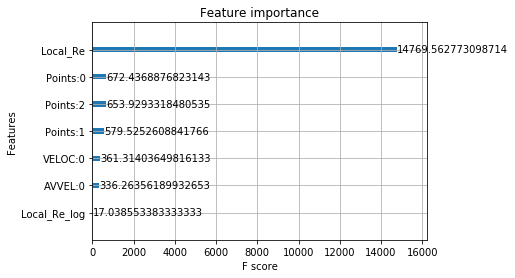

In [178]:
xgb.plot_importance(test_model, importance_type="gain")

In [29]:
test_row = cleaned_data.iloc[[1]]
#xgb.DMatrix(data=)

In [30]:
test_x = test_row.drop(columns=['y_plus','u_plus'])
test_y = test_row['u_plus']

In [31]:
test_model.predict(data=test_x)

array([0.7021724], dtype=float32)

# Build Model

In [8]:
default_params = dict(max_depth=5,
              colsample_bytree=1,
              subsample = 1,
              learning_rate=0.08,
              objective="reg:squarederror",
              n_estimators =500,
              silent=0,
              reg_alpha=0,
              reg_lambda=10,
              booster='gbtree')

In [8]:
def build_model(parameters):
    
    model = xgb.XGBRegressor(objective="reg:squarederror", n_jobs=-1)
    estimator = model.fit(train_x, train_y, eval_set=eval_set,
                         eval_metric="rmse", early_stopping_rounds=100,)
    
    return estimator
    

In [35]:
dataframe = cleaned_data.sample(frac=0.1)
train_data, validation_data = train_test_split(dataframe, test_size=0.3,
                                              random_state=10)
train_x, train_y = X_Y_split(train_data)
validation_x, validation_y = X_Y_split(validation_data)
eval_set = [(train_x,train_y),(validation_x,validation_y)]
dtrain = xgb.DMatrix(data=train_x, label=train_y, 
                     feature_names=train_x.columns)
dval  = xgb.DMatrix(data=validation_x, label=validation_y, 
                    feature_names=validation_x.columns)
eval_mat = [(dtrain, "train"), (dval, "validation")]

In [80]:
build_model(parameters)

[0]	validation_0-rmse:12.4897	validation_1-rmse:12.5812
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:11.2975	validation_1-rmse:11.3828
[2]	validation_0-rmse:10.2291	validation_1-rmse:10.3092
[3]	validation_0-rmse:9.27333	validation_1-rmse:9.34962
[4]	validation_0-rmse:8.41912	validation_1-rmse:8.49162
[5]	validation_0-rmse:7.65724	validation_1-rmse:7.72788
[6]	validation_0-rmse:6.9778	validation_1-rmse:7.04548
[7]	validation_0-rmse:6.37397	validation_1-rmse:6.43958
[8]	validation_0-rmse:5.83948	validation_1-rmse:5.9031
[9]	validation_0-rmse:5.36642	validation_1-rmse:5.42857
[10]	validation_0-rmse:4.94944	validation_1-rmse:5.01077
[11]	validation_0-rmse:4.58385	validation_1-rmse:4.64434
[12]	validation_0-rmse:4.26424	validation_1-rmse:4.32362
[13]	validation_0-rmse:3.9859	validation_1-rmse:4.04497
[14]	validation_0-rmse:3.74507	validation_1-rmse:3.8037

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [86]:
xgb.train(params=default_params, dtrain=dtrain, num_boost_round=1000,
         evals=eval_mat,early_stopping_rounds=50)

[0]	train-rmse:12.7574	validation-rmse:12.8503
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 50 rounds.
[1]	train-rmse:11.7827	validation-rmse:11.8708
[2]	train-rmse:10.8888	validation-rmse:10.9727
[3]	train-rmse:10.0694	validation-rmse:10.1501
[4]	train-rmse:9.31903	validation-rmse:9.39692
[5]	train-rmse:8.63209	validation-rmse:8.707
[6]	train-rmse:8.00397	validation-rmse:8.07653
[7]	train-rmse:7.43043	validation-rmse:7.50081
[8]	train-rmse:6.90691	validation-rmse:6.97561
[9]	train-rmse:6.42979	validation-rmse:6.4971
[10]	train-rmse:5.99504	validation-rmse:6.0614
[11]	train-rmse:5.60025	validation-rmse:5.66611
[12]	train-rmse:5.24246	validation-rmse:5.30729
[13]	train-rmse:4.91779	validation-rmse:4.98171
[14]	train-rmse:4.624	validation-rmse:4.68658
[15]	train-rmse:4.35939	validation-rmse:4.42258
[16]	train-rmse:4.12026	validation-rmse:4.18322
[17]	train-rmse:3.90636	validation-rmse:3.969

[168]	train-rmse:1.75666	validation-rmse:1.92894
[169]	train-rmse:1.75626	validation-rmse:1.92881
[170]	train-rmse:1.75484	validation-rmse:1.92924
[171]	train-rmse:1.75383	validation-rmse:1.92875
[172]	train-rmse:1.75299	validation-rmse:1.9284
[173]	train-rmse:1.75262	validation-rmse:1.9284
[174]	train-rmse:1.74968	validation-rmse:1.92605
[175]	train-rmse:1.74579	validation-rmse:1.92309
[176]	train-rmse:1.74124	validation-rmse:1.91985
[177]	train-rmse:1.73853	validation-rmse:1.91814
[178]	train-rmse:1.73677	validation-rmse:1.91742
[179]	train-rmse:1.73631	validation-rmse:1.91723
[180]	train-rmse:1.73277	validation-rmse:1.91476
[181]	train-rmse:1.73147	validation-rmse:1.91424
[182]	train-rmse:1.73123	validation-rmse:1.91434
[183]	train-rmse:1.72913	validation-rmse:1.91317
[184]	train-rmse:1.72533	validation-rmse:1.91003
[185]	train-rmse:1.72392	validation-rmse:1.90964
[186]	train-rmse:1.72309	validation-rmse:1.90908
[187]	train-rmse:1.72122	validation-rmse:1.9079
[188]	train-rmse:1.7209

[337]	train-rmse:1.54283	validation-rmse:1.79969
[338]	train-rmse:1.5422	validation-rmse:1.79994
[339]	train-rmse:1.54211	validation-rmse:1.79991
[340]	train-rmse:1.54177	validation-rmse:1.79977
[341]	train-rmse:1.54088	validation-rmse:1.7996
[342]	train-rmse:1.53982	validation-rmse:1.7991
[343]	train-rmse:1.5393	validation-rmse:1.79917
[344]	train-rmse:1.53854	validation-rmse:1.79933
[345]	train-rmse:1.53807	validation-rmse:1.79955
[346]	train-rmse:1.53621	validation-rmse:1.79803
[347]	train-rmse:1.53612	validation-rmse:1.798
[348]	train-rmse:1.53531	validation-rmse:1.79798
[349]	train-rmse:1.53519	validation-rmse:1.7979
[350]	train-rmse:1.5351	validation-rmse:1.79786
[351]	train-rmse:1.53405	validation-rmse:1.79786
[352]	train-rmse:1.53326	validation-rmse:1.79797
[353]	train-rmse:1.5331	validation-rmse:1.798
[354]	train-rmse:1.53241	validation-rmse:1.79808
[355]	train-rmse:1.53167	validation-rmse:1.79795
[356]	train-rmse:1.52954	validation-rmse:1.79632
[357]	train-rmse:1.52946	valida

[506]	train-rmse:1.41231	validation-rmse:1.7334
[507]	train-rmse:1.41164	validation-rmse:1.73323
[508]	train-rmse:1.41098	validation-rmse:1.73328
[509]	train-rmse:1.41044	validation-rmse:1.73333
[510]	train-rmse:1.40984	validation-rmse:1.73313
[511]	train-rmse:1.4085	validation-rmse:1.73231
[512]	train-rmse:1.40793	validation-rmse:1.73216
[513]	train-rmse:1.40563	validation-rmse:1.73014
[514]	train-rmse:1.40521	validation-rmse:1.73022
[515]	train-rmse:1.40474	validation-rmse:1.73026
[516]	train-rmse:1.40432	validation-rmse:1.73022
[517]	train-rmse:1.4032	validation-rmse:1.72917
[518]	train-rmse:1.40265	validation-rmse:1.72915
[519]	train-rmse:1.4022	validation-rmse:1.72913
[520]	train-rmse:1.40187	validation-rmse:1.72898
[521]	train-rmse:1.40165	validation-rmse:1.72883
[522]	train-rmse:1.40156	validation-rmse:1.72879
[523]	train-rmse:1.40111	validation-rmse:1.72885
[524]	train-rmse:1.40014	validation-rmse:1.7282
[525]	train-rmse:1.39759	validation-rmse:1.72657
[526]	train-rmse:1.3968	v

[675]	train-rmse:1.2905	validation-rmse:1.67214
[676]	train-rmse:1.29025	validation-rmse:1.67206
[677]	train-rmse:1.28998	validation-rmse:1.67199
[678]	train-rmse:1.28946	validation-rmse:1.67197
[679]	train-rmse:1.28904	validation-rmse:1.67198
[680]	train-rmse:1.28886	validation-rmse:1.67192
[681]	train-rmse:1.28831	validation-rmse:1.67181
[682]	train-rmse:1.2881	validation-rmse:1.67195
[683]	train-rmse:1.28778	validation-rmse:1.67208
[684]	train-rmse:1.28754	validation-rmse:1.67202
[685]	train-rmse:1.2873	validation-rmse:1.67209
[686]	train-rmse:1.28717	validation-rmse:1.67214
[687]	train-rmse:1.28703	validation-rmse:1.67226
[688]	train-rmse:1.28683	validation-rmse:1.67214
[689]	train-rmse:1.28654	validation-rmse:1.6723
[690]	train-rmse:1.28625	validation-rmse:1.67225
[691]	train-rmse:1.28597	validation-rmse:1.67246
[692]	train-rmse:1.28572	validation-rmse:1.67237
[693]	train-rmse:1.28548	validation-rmse:1.67231
[694]	train-rmse:1.2854	validation-rmse:1.67226
[695]	train-rmse:1.28518	

[844]	train-rmse:1.21463	validation-rmse:1.64579
[845]	train-rmse:1.21419	validation-rmse:1.64575
[846]	train-rmse:1.21377	validation-rmse:1.64589
[847]	train-rmse:1.213	validation-rmse:1.64579
[848]	train-rmse:1.21267	validation-rmse:1.64589
[849]	train-rmse:1.21207	validation-rmse:1.64601
[850]	train-rmse:1.21178	validation-rmse:1.64611
[851]	train-rmse:1.21137	validation-rmse:1.646
[852]	train-rmse:1.21134	validation-rmse:1.646
[853]	train-rmse:1.21082	validation-rmse:1.64612
[854]	train-rmse:1.2108	validation-rmse:1.64612
[855]	train-rmse:1.21042	validation-rmse:1.64604
[856]	train-rmse:1.21007	validation-rmse:1.64603
[857]	train-rmse:1.20976	validation-rmse:1.64618
[858]	train-rmse:1.20914	validation-rmse:1.64594
[859]	train-rmse:1.20891	validation-rmse:1.64585
[860]	train-rmse:1.20858	validation-rmse:1.64583
[861]	train-rmse:1.20832	validation-rmse:1.64559
[862]	train-rmse:1.2081	validation-rmse:1.64546
[863]	train-rmse:1.2078	validation-rmse:1.64543
[864]	train-rmse:1.20747	vali

In [ ]:
model_test.model.fit()

In [9]:
#%autoreload 2
model_test = XGBoost_Model(default_params, cleaned_data )

[0]	validation_0-rmse:12.8018	validation_1-rmse:12.8028
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:11.8202	validation_1-rmse:11.8208
[2]	validation_0-rmse:10.9202	validation_1-rmse:10.9202
[3]	validation_0-rmse:10.0958	validation_1-rmse:10.0954
[4]	validation_0-rmse:9.3405	validation_1-rmse:9.33918
[5]	validation_0-rmse:8.64974	validation_1-rmse:8.6479
[6]	validation_0-rmse:8.01855	validation_1-rmse:8.01604
[7]	validation_0-rmse:7.44216	validation_1-rmse:7.43889
[8]	validation_0-rmse:6.91612	validation_1-rmse:6.91237
[9]	validation_0-rmse:6.43695	validation_1-rmse:6.4327
[10]	validation_0-rmse:6.0006	validation_1-rmse:5.99568
[11]	validation_0-rmse:5.60431	validation_1-rmse:5.59928
[12]	validation_0-rmse:5.24506	validation_1-rmse:5.23989
[13]	validation_0-rmse:4.91881	validation_1-rmse:4.91355
[14]	validation_0-rmse:4.62553	validation_1-rmse:4.61994


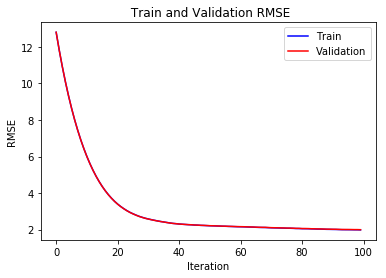

In [40]:
fitted_model = model_test.fit(n_estimators=100)

In [10]:
model_test.train_model(num_rounds=1000)

[0]	train-rmse:12.802	validation-rmse:12.8031
Multiple eval metrics have been passed: 'validation-rmse' will be used for early stopping.

Will train until validation-rmse hasn't improved in 50 rounds.
[1]	train-rmse:11.8204	validation-rmse:11.821
[2]	train-rmse:10.9205	validation-rmse:10.9203
[3]	train-rmse:10.096	validation-rmse:10.0955
[4]	train-rmse:9.34069	validation-rmse:9.33935
[5]	train-rmse:8.64993	validation-rmse:8.64804
[6]	train-rmse:8.01874	validation-rmse:8.01616
[7]	train-rmse:7.44231	validation-rmse:7.43897
[8]	train-rmse:6.91625	validation-rmse:6.91251
[9]	train-rmse:6.43705	validation-rmse:6.43282
[10]	train-rmse:6.00072	validation-rmse:5.99578
[11]	train-rmse:5.60444	validation-rmse:5.59934
[12]	train-rmse:5.24517	validation-rmse:5.23998
[13]	train-rmse:4.91891	validation-rmse:4.91366
[14]	train-rmse:4.62562	validation-rmse:4.62003
[15]	train-rmse:4.36097	validation-rmse:4.3548
[16]	train-rmse:4.12324	validation-rmse:4.11713
[17]	train-rmse:3.91021	validation-rmse:3.9

[167]	train-rmse:1.78274	validation-rmse:1.798
[168]	train-rmse:1.78237	validation-rmse:1.79766
[169]	train-rmse:1.77836	validation-rmse:1.79364
[170]	train-rmse:1.77702	validation-rmse:1.79237
[171]	train-rmse:1.77668	validation-rmse:1.79206
[172]	train-rmse:1.77467	validation-rmse:1.79008
[173]	train-rmse:1.77444	validation-rmse:1.78986
[174]	train-rmse:1.77161	validation-rmse:1.78717
[175]	train-rmse:1.76861	validation-rmse:1.78435
[176]	train-rmse:1.76701	validation-rmse:1.7828
[177]	train-rmse:1.76669	validation-rmse:1.78251
[178]	train-rmse:1.7661	validation-rmse:1.78196
[179]	train-rmse:1.7649	validation-rmse:1.78091
[180]	train-rmse:1.76469	validation-rmse:1.7807
[181]	train-rmse:1.76416	validation-rmse:1.78022
[182]	train-rmse:1.76167	validation-rmse:1.77789
[183]	train-rmse:1.76114	validation-rmse:1.7774
[184]	train-rmse:1.75915	validation-rmse:1.77561
[185]	train-rmse:1.75688	validation-rmse:1.77355
[186]	train-rmse:1.75363	validation-rmse:1.77033
[187]	train-rmse:1.75205	va

[336]	train-rmse:1.56721	validation-rmse:1.59294
[337]	train-rmse:1.56687	validation-rmse:1.5926
[338]	train-rmse:1.56657	validation-rmse:1.59237
[339]	train-rmse:1.56609	validation-rmse:1.59204
[340]	train-rmse:1.56589	validation-rmse:1.59183
[341]	train-rmse:1.56579	validation-rmse:1.59173
[342]	train-rmse:1.56568	validation-rmse:1.59163
[343]	train-rmse:1.56342	validation-rmse:1.5895
[344]	train-rmse:1.56083	validation-rmse:1.58701
[345]	train-rmse:1.5603	validation-rmse:1.5865
[346]	train-rmse:1.55954	validation-rmse:1.58584
[347]	train-rmse:1.55928	validation-rmse:1.58564
[348]	train-rmse:1.55879	validation-rmse:1.58525
[349]	train-rmse:1.55774	validation-rmse:1.58414
[350]	train-rmse:1.55517	validation-rmse:1.58161
[351]	train-rmse:1.55385	validation-rmse:1.58028
[352]	train-rmse:1.55373	validation-rmse:1.58015
[353]	train-rmse:1.55345	validation-rmse:1.57983
[354]	train-rmse:1.55335	validation-rmse:1.57973
[355]	train-rmse:1.55247	validation-rmse:1.57884
[356]	train-rmse:1.55242

[504]	train-rmse:1.45079	validation-rmse:1.4843
[505]	train-rmse:1.45054	validation-rmse:1.48405
[506]	train-rmse:1.45034	validation-rmse:1.48396
[507]	train-rmse:1.44947	validation-rmse:1.48307
[508]	train-rmse:1.44784	validation-rmse:1.48143
[509]	train-rmse:1.44778	validation-rmse:1.48138
[510]	train-rmse:1.44762	validation-rmse:1.48135
[511]	train-rmse:1.44748	validation-rmse:1.48126
[512]	train-rmse:1.44743	validation-rmse:1.48121
[513]	train-rmse:1.44738	validation-rmse:1.48117
[514]	train-rmse:1.44715	validation-rmse:1.48102
[515]	train-rmse:1.44601	validation-rmse:1.47984
[516]	train-rmse:1.44404	validation-rmse:1.47799
[517]	train-rmse:1.44007	validation-rmse:1.47412
[518]	train-rmse:1.43623	validation-rmse:1.4704
[519]	train-rmse:1.4359	validation-rmse:1.47019
[520]	train-rmse:1.43528	validation-rmse:1.46958
[521]	train-rmse:1.43515	validation-rmse:1.46953
[522]	train-rmse:1.43407	validation-rmse:1.46851
[523]	train-rmse:1.43305	validation-rmse:1.46749
[524]	train-rmse:1.4326

[672]	train-rmse:1.36806	validation-rmse:1.40831
[673]	train-rmse:1.36801	validation-rmse:1.40826
[674]	train-rmse:1.36794	validation-rmse:1.40825
[675]	train-rmse:1.36776	validation-rmse:1.40812
[676]	train-rmse:1.36773	validation-rmse:1.40808
[677]	train-rmse:1.36726	validation-rmse:1.40769
[678]	train-rmse:1.36718	validation-rmse:1.40765
[679]	train-rmse:1.36711	validation-rmse:1.40759
[680]	train-rmse:1.36705	validation-rmse:1.40755
[681]	train-rmse:1.36663	validation-rmse:1.4072
[682]	train-rmse:1.36657	validation-rmse:1.40714
[683]	train-rmse:1.36587	validation-rmse:1.40647
[684]	train-rmse:1.36569	validation-rmse:1.40629
[685]	train-rmse:1.36435	validation-rmse:1.40499
[686]	train-rmse:1.36361	validation-rmse:1.40438
[687]	train-rmse:1.36097	validation-rmse:1.40158
[688]	train-rmse:1.36085	validation-rmse:1.40149
[689]	train-rmse:1.36071	validation-rmse:1.40137
[690]	train-rmse:1.3597	validation-rmse:1.40044
[691]	train-rmse:1.35961	validation-rmse:1.40038
[692]	train-rmse:1.359

[840]	train-rmse:1.27237	validation-rmse:1.31737
[841]	train-rmse:1.2707	validation-rmse:1.31569
[842]	train-rmse:1.27047	validation-rmse:1.31547
[843]	train-rmse:1.27011	validation-rmse:1.31512
[844]	train-rmse:1.27004	validation-rmse:1.31509
[845]	train-rmse:1.26999	validation-rmse:1.31505
[846]	train-rmse:1.26992	validation-rmse:1.31505
[847]	train-rmse:1.26985	validation-rmse:1.31499
[848]	train-rmse:1.26964	validation-rmse:1.31481
[849]	train-rmse:1.26961	validation-rmse:1.31477
[850]	train-rmse:1.26954	validation-rmse:1.31472
[851]	train-rmse:1.26935	validation-rmse:1.31458
[852]	train-rmse:1.26931	validation-rmse:1.31455
[853]	train-rmse:1.2691	validation-rmse:1.31434
[854]	train-rmse:1.26906	validation-rmse:1.3143
[855]	train-rmse:1.26899	validation-rmse:1.31428
[856]	train-rmse:1.26871	validation-rmse:1.31414
[857]	train-rmse:1.26853	validation-rmse:1.31405
[858]	train-rmse:1.2682	validation-rmse:1.31378
[859]	train-rmse:1.26808	validation-rmse:1.31376
[860]	train-rmse:1.26805

In [12]:
model_test.model.predict(dval)

NameError: name 'dval' is not defined

Best: -5.330591 using {'learning_rate': 0.1411111111111111}


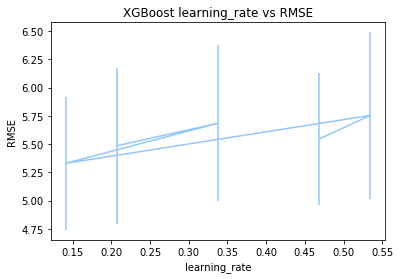

In [10]:
tuning_param = "learning_rate"
model_test.tune_model_parameter(tuning_param, parameters.get(tuning_param), randomized=True, 
               n_splits=4, n_iter=5,data_size=0.01, fit_param=True)